In [55]:
## Bring in needed mods
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as ss, seaborn as sns
import sys
#sys.path.insert(0, '/../../QTL-functions/SCRIPTS/')
import qtlfunctions as QTLfun
import qtlmovie as QTLmovies

def allelic_manu(geno,pheno,x=0,y=1): ## geno and pheno need to be in the same position
    """
    Conducts a Mann-Whitney U test on the phenotype data in PHENO
    by the genotypic states listed in GENO.
    
    Assumes the order of data within GENO and PHENO are paired.
    Defaluts for the biallelic stat in GENO are 0 and 1; set in X and Y.
    
    Returns the -log10 of the calculated p-value
    """
    pheno = np.array(pheno) ## sets the type for the data as an array
    geno = np.array(geno)
    ## Gather phenotypes by genotypes 
    ## Parse the genotype data as True for 0 and then 1 and 
    ## take the asscoiated index within the phenotypic data array
    ## Return p-value
    return -np.log10(ss.mannwhitneyu(pheno[(geno==x)],pheno[(geno==y)])[1])

def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. 
        Return F-statistic.
    """
    coding = np.array(site,float)
    pheno = np.array(pheno,float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    R = (len_yhat/len_y)**2
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F,R

def association_logPval(site, pheno):
    F,R = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP,R

In [2]:
%matplotlib inline

In [3]:
## Set the random seed
np.random.seed(71191)

## Define parental labels
parents = ['Bt22','Ftc555-1']

In [4]:
## Set paths to phenotype data
## 1) the parental data (parents)
## 2) the initial set of segregants (old)
## 3) the latest set of segregants (new)
## Note, these data where previously processed
## And the halo per replicates / experimetns where calcualted
parent_data_path = "../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_new_parents.csv"
Old_data_path = "../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_old.csv"
New_data_path = "../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_new.csv"

## set path to genotype data and chromosome map
chrommap_path = '../../GENOTYPE/H99_chrommap.csv'

In [5]:
## Bring in genotype data gather the segregants
## and show the frist five rows
loci_path = "../../GENOTYPE/Bt22xFtc555-1_loci_cor.csv.gz"
geno = pd.read_csv(loci_path, index_col = 0)
geno_segs = [s for s in geno.columns if s[:3] == "PMY"]
geno.head()

,Chrom,Pos,Alleles,Type,Newpos,Newchrom,Oldchrom,Maf,PMY2556,PMY2558,...,PMY2931,PMY2932,PMY2933,PMY2934,PMY2935,PMY2936,PMY2937,PMY2938,PMY2939,PMY2940
Oldindex,,,,,,,,,,,,,,,,,,,,,
5,1,25980,C.T,snp,25980,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
7,1,26119,ATT.GTT,snp,26119,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
12,1,26587,ACCTT.TCCAT.TCCTT.GCCTT,complex,26587,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
15,1,27290,TCCC.CCCC,snp,27290,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0
17,1,28274,GCGCT.ACGCT,snp,28274,1.0,1.0,0.491857,1,0,...,0,1,1,0,1,0,1,1,0,0


In [6]:
## Print the shape
geno.shape

(46760, 330)

In [7]:
## How many segregants are in the genotype data?
len(geno_segs)

322

In [8]:
## Load in chrommap, check length, show head
chrommap = pd.read_csv(chrommap_path)
chrommap.shape[0] >= geno.Chrom.unique().shape[0]
chrommap.head()

,Chrom,Seqid,Length,Cumpos,Midpts
0,1,CP003820.1,2291499,0,1145749.5
1,2,CP003821.1,1621675,2291499,3102336.5
2,3,CP003822.1,1575141,3913174,4700744.5
3,4,CP003823.1,1084805,5488315,6030717.5
4,5,CP003824.1,1814975,6573120,7480607.5


In [9]:
## Bring in GFF file
gffpath = 'C:/Users/tsauters/Documents/GitHub/Bt22xFtc555-1/GENOTYPE/FungiDB-46_CneoformansH99.gff'
names = ["Seqid", "Source", "Type", "Start", "End", "Score", 
         "Strand", "Phase", "Attribute"]
dtype = ["str","str","str","int","int","str","str","str","str"]

gff = pd.read_csv(gffpath,comment='#',
                  sep='\t',header=None,
                  names=names,dtype=dict(zip(names,dtype)))

gff['Strand'] = gff['Strand'].replace(dict(zip(['-','+'],[-1,1])))
gff['Parent'] = [a.split('Parent=')[-1].split(';')[0].split('ID=')[-1] 
                 for a in gff.Attribute ]

gff['Gene'] = [a.split('-t26')[0] for a in gff.Parent]

gff = gff.merge(chrommap)

In [10]:
## Gather parental data
## and average by replicate per experiment
PNd = pd.read_csv(parent_data_path)
PNda = PNd.groupby(["PMY","Z"]).mean().reset_index().groupby("PMY").mean().reset_index()
PNda.drop("Z", axis = 1, inplace = True)

## Gather PMY numbers of paretns
Parent_PMY = PNda.PMY.tolist()

## view head
PNda.head()

,PMY,Replicate,Halo
0,PMY2649,2.041667,4.777181
1,PMY2650,2.000000,1.036667


In [11]:
PNd

,PMY,Replicate,Halo,Z
0,PMY2649,1,6.904,0
1,PMY2649,2,4.097,0
2,PMY2649,3,7.451,0
3,PMY2649,1,7.280,1
4,PMY2649,2,6.854,1
...,...,...,...,...
66,PMY2650,2,1.870,22
67,PMY2650,3,1.490,22
68,PMY2650,1,1.029,23
69,PMY2650,2,1.257,23


In [12]:
## Gather the latest data and average across repliacates, view head
Nd = pd.read_csv(New_data_path)
Nda = Nd[~(Nd.isin(Parent_PMY))].groupby("PMY").mean().reset_index()
Nda.head()

,PMY,Replicate,Halo
0,PMY2603,2.0,1.194667
1,PMY2604,2.0,2.377667
2,PMY2605,2.0,6.427667
3,PMY2606,2.0,1.315333
4,PMY2607,2.0,2.287000


In [13]:
Nd.head()

,PMY,Replicate,Halo
0,PMY2603,1,1.383
1,PMY2603,2,0.820
2,PMY2603,3,1.381
3,PMY2604,1,2.483
4,PMY2604,2,2.759


In [14]:
## For the inital (old) data load in and average replicates
Od = pd.read_csv(Old_data_path)
Oda = Od[~(Od.isin(Parent_PMY))].groupby("PMY").mean().reset_index()
Oda.head()

,PMY,Replicate,Halo
0,PMY2556,1.5,3.3180
1,PMY2557,1.5,2.5775
2,PMY2558,1.5,1.0930
3,PMY2559,1.5,0.6710
4,PMY2560,1.5,0.6040


In [15]:
Od.head()

,PMY,Replicate,Halo
0,PMY2556,1,2.613
1,PMY2556,2,4.023
2,PMY2557,1,2.666
3,PMY2557,2,2.489
4,PMY2558,1,0.927


In [16]:
## Concatonate resluts
Halo = pd.concat([PNda, Oda, Nda]).reset_index(drop = True)

## Convert inches to cm
Halo["Halo_in"] = Halo.Halo
cm_con = 2.54
Halo["Halo"] = (np.sqrt(Halo.Halo_in.values)*cm_con)**2

## Set index
Halo.index = Halo.PMY
## View head
Halo.head()

,PMY,Replicate,Halo,Halo_in
PMY,,,,
PMY2649,PMY2649,2.041667,30.820458,4.777181
PMY2650,PMY2650,2.000000,6.688159,1.036667
PMY2556,PMY2556,1.500000,21.406409,3.318000
PMY2557,PMY2557,1.500000,16.628999,2.577500
PMY2558,PMY2558,1.500000,7.051599,1.093000


In [17]:
spr = pd.concat([Od, Nd]).reset_index(drop = True)

spr["Halo_in"] = spr.Halo
cm_con = 2.54
spr["Halo"] = (np.sqrt(spr.Halo_in.values)*cm_con)**2

## Set index
#spr.index = spr.PMY
## View head
spr.head()

,PMY,Replicate,Halo,Halo_in
0,PMY2556,1,16.858031,2.613
1,PMY2556,2,25.954787,4.023
2,PMY2557,1,17.199966,2.666
3,PMY2557,2,16.058032,2.489
4,PMY2558,1,5.980633,0.927


In [18]:
spr_piv = spr.pivot_table(index = 'PMY',
          columns = 'Replicate',
         values = 'Halo',
               aggfunc= 'mean')

spr_piv.head()

Replicate,1,2,3
PMY,,,
PMY2556,16.858031,25.954787,NaN
PMY2557,17.199966,16.058032,NaN
PMY2558,5.980633,8.122564,NaN
PMY2559,4.193540,4.464507,NaN
PMY2560,3.870960,3.922573,NaN


In [19]:
ss.spearmanr(spr_piv, nan_policy='omit')

SpearmanrResult(correlation=array([[1.        , 0.73170362, 0.88753746],
       [0.73170362, 1.        , 0.70306659],
       [0.88753746, 0.70306659, 1.        ]]), pvalue=array([[0.00000000e+000, 3.12901568e-064, 4.53051644e-111],
       [3.12901568e-064, 0.00000000e+000, 3.39501465e-050],
       [4.53051644e-111, 3.39501465e-050, 0.00000000e+000]]))

In [20]:
## Check the number of times each sample appears in dataframe
pmy, pn = np.unique(Halo.PMY.values, return_counts = True)

if np.max(pn)>1:
    print(pmy[(pn>1)])

In [21]:
## Gather segregants with both genotype and phenotype data
Map_pop = [s for s in Halo.PMY.unique() if s in geno_segs]
len(Map_pop) ## print # of segregants

322

In [22]:
myylabel = 'Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

In [23]:
Parent_PMY

['PMY2649', 'PMY2650']

In [24]:
Halo.to_csv('../../PHENOTYPE/AMOEBA/HALOS/bt22xftc555_halo_average.csv.gz',
            index=False)
Halo = Halo.loc[Map_pop,:]

In [25]:
poor_growth = ['PMY2558', 'PMY2615', 'PMY2626']

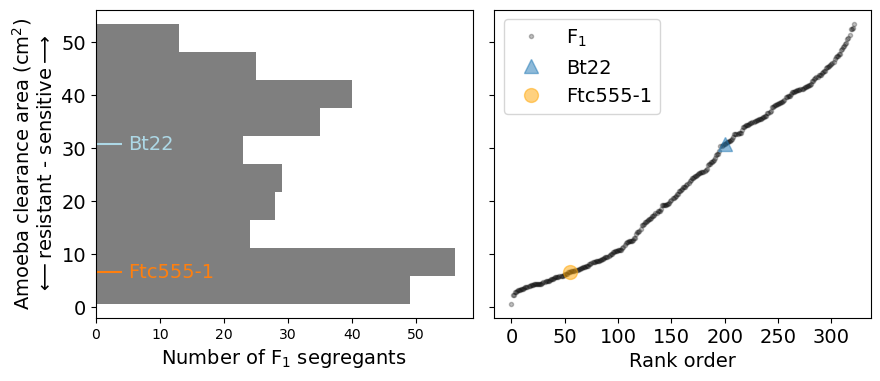

In [26]:
## Plot segregants
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)

plt.sca(ax[0])
## Plot all
plt.hist(Halo[(Halo.PMY.isin(Map_pop))].Halo.values,
         color='k',alpha=0.5,
         orientation='horizontal')
         
## Label x and y axis
plt.ylabel(myylabel,fontsize=14)
plt.xlabel('Number of F$_1$ segregants',fontsize=14);

## Plot parents

ftc555_growth = Halo[(Halo.PMY==Parent_PMY[1])].Halo
plt.hlines(ftc555_growth,
           0,4,color='tab:orange')

## annotate the parental strain name
plt.text(5,ftc555_growth,s=parents[1],
         va='center',ha='left',
         fontsize=14,color='tab:orange')


## Plot parents
bt22_growth = Halo[(Halo.PMY==Parent_PMY[0])].Halo
plt.hlines(bt22_growth,
           0,4,color='lightblue')
## annotate the parental strain name
plt.text(5,bt22_growth,s=parents[0],
         va='center',ha='left',
         fontsize=14,color='lightblue');

#plt.xticks(np.arange(0,25,5),fontsize=14)
plt.yticks(fontsize=14)
## Summon the legend
#plt.legend(fontsize=14);

plt.sca(ax[1])
Halo_sorted = Halo.sort_values('Halo').reset_index(drop=True)
Halo_sorted_seg = Halo_sorted[~(Halo_sorted.PMY.isin(Parent_PMY))]
plt.plot(Halo_sorted.index,
        Halo_sorted.Halo.values,
         'k.',alpha=0.25,label='F$_{1}$');



for i,p in enumerate(Parent_PMY):
    
    plt.plot(Halo_sorted[(Halo_sorted.PMY==p)].index,
               Halo_sorted[(Halo_sorted.PMY==p)].Halo.values,
         'o' if i ==1 else '^',alpha=0.5,label=parents[i],
             color='orange' if i == 1 else 'tab:blue',ms=10);
    
#for i,p in enumerate(poor_growth):
#    
#    plt.plot(Halo_sorted[(Halo_sorted.PMY==p)].index,
#               Halo_sorted[(Halo_sorted.PMY==p)].Halo.values,
#             '.',label=p,color='r',ms=12,alpha=0.58);
    
plt.xlabel('Rank order',fontsize=14);
plt.xticks(fontsize=14)
#plt.ylabel(myylabel,
#           fontsize=14)
plt.legend(fontsize=14);
plt.subplots_adjust(wspace=0.058)
plt.savefig('C:/Users/tsauters/Pictures/scientific figures/Bt22xFtc555-1_amoeba_assay.png',
            dpi=150,bbox_inches='tight');

In [27]:
Halo.head()

,PMY,Replicate,Halo,Halo_in
PMY,,,,
PMY2649,PMY2649,2.041667,30.820458,4.777181
PMY2650,PMY2650,2.000000,6.688159,1.036667
PMY2556,PMY2556,1.500000,21.406409,3.318000
PMY2558,PMY2558,1.500000,7.051599,1.093000
PMY2559,PMY2559,1.500000,4.329024,0.671000


In [28]:
halo = Halo.loc[Map_pop]['Halo'].values
halo[:5]

array([30.82045807,  6.68815867, 21.4064088 ,  7.0515988 ,  4.3290236 ])

In [29]:
Halo.Halo.mean(), Halo.Halo.std()

(23.458729157160118, 14.98627754177948)

In [30]:
pvaldf = QTLfun.QTLmap(geno,QTLfun.association_logPval,
                       Map_pop,halo)

In [31]:
pvaldf = pvaldf.sort_values(['Chrom','Pos']
                           ).reset_index(drop=True)

In [32]:
kix = []
for i,c in pvaldf.groupby('Chrom'):
    
    #ixn = 200 if i != 8 else 45
    ixn = 1000 if i!= 8 else 200
    
    kc = c.index[::ixn]
    
    kix.append(kc)
    
k = list(np.concatenate(kix)) + [pvaldf.index.max()]
len(k)

69

In [33]:
chrommap = QTLfun.chrommap(pvaldf)
chrompad = np.cumsum(200000*np.ones(len(chrommap)))
chrommap['Cumlen'] = chrommap.Cumlen + chrompad
chrommap['Midpts'] = chrommap.Midpts + chrompad
chrommap.head()

,Chrom,Length,Cumlen,Midpts
0,1,2264002,200000.0,1332001.0
1,2,1619187,2664002.0,3473595.5
2,3,1554360,4483189.0,5260369.0
3,4,1059391,6237549.0,6767244.5
4,5,1793420,7496940.0,8393650.0


In [34]:
mpvaldf = pvaldf.merge(chrommap)
mpvaldf['Cumpos'] = mpvaldf.Pos + mpvaldf.Cumlen

In [35]:
QTLix = pvaldf.QTL.idxmax()

In [36]:
## Set significance threshold for QTL mapping
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
threshold = 3.928068319177378## 0.05 threshold

## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno = Halo.Halo.values
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

## Gather loci and intiate null distrbution
loci = geno[Map_pop].drop_duplicates() 

if threshold < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci.apply(association_logPval,
                               args=[perms_pheno[i]],
                               axis=1).max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold = np.percentile(null,95 if perms <= 1000 else 99)

In [37]:
chrommap

,Chrom,Length,Cumlen,Midpts
0,1,2264002,200000.0,1332001.0
1,2,1619187,2664002.0,3473595.5
2,3,1554360,4483189.0,5260369.0
3,4,1059391,6237549.0,6767244.5
4,5,1793420,7496940.0,8393650.0
5,6,1417305,9490360.0,10199012.5
6,7,1374738,11107665.0,11795034.0
7,8,1387111,12682403.0,13375958.5
8,9,1155758,14269514.0,14847393.0
9,10,1051064,15625272.0,16150804.0


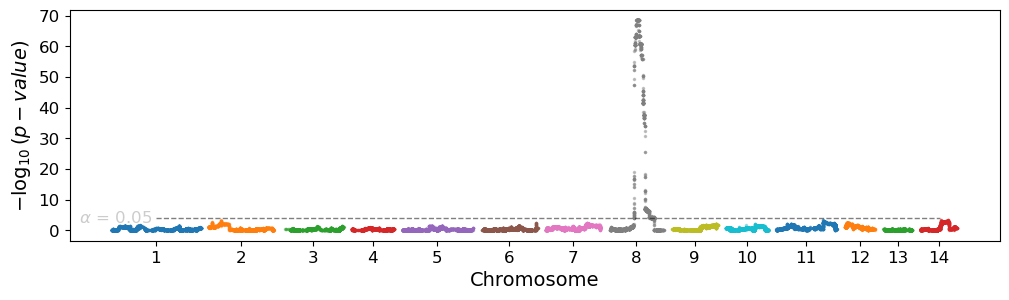

In [38]:
## Make a Manhattan plot
fig,ax = plt.subplots(1,1,figsize=(12,3)) ## Makes a figure instance
fig.set_facecolor('w')
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap 
                                     ## except last one do the following ...    
    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.plot(temp.Pos.values+cumpos,temp.QTL.values,
             '.',markersize=3,alpha=0.4); ## plots the data x vs y
plt.hlines(threshold,chrommap.Midpts.min(),
           21*10**6,linewidth=1,alpha=0.5,
           linestyle='--',color='k')

plt.text(chrommap.Midpts.min()-100000,threshold,
         '$\u03B1$ = 0.05',
         fontsize=12,alpha=0.2,
         ha='right',va='center')

plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
           fontsize=12); ## set location, labels and fontsize of x tics.
#plt.ylim(0,10)
plt.savefig("../../FIGURES/Amoeba_Halo_QTL_aov_Bt22xFtc555-1.png",
            dpi = 200, bbox_inches = "tight") ## Save figure

In [39]:
## Make a genotype by phenotype dataframe at QTL peak
## Find QTL idnex
#Qtl_ix = pvaldf.Pval.idxmax()

Qtl_ix = pvaldf.QTL.idxmax()

## Take genotype values and rename column
Qtl = pvaldf.loc[[Qtl_ix], sorted(Map_pop)].T
Qtl.columns = ["GT"]

## Find assocaited phenotypes view head
Qtl["Halo"] = Halo.loc[sorted(Map_pop), "Halo"].values
Qtl.head()

,GT,Halo
PMY2556,1.0,21.406409
PMY2558,1.0,7.051599
PMY2559,1.0,4.329024
PMY2560,1.0,3.896766
PMY2561,1.0,10.764495


In [40]:
import statsmodels.formula.api as smf, seaborn as sns

In [41]:
res = smf.ols('Halo~GT',data=Qtl).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Halo   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     523.2
Date:                Sun, 06 Nov 2022   Prob (F-statistic):           2.68e-69
Time:                        11:22:49   Log-Likelihood:                -1172.1
No. Observations:                 322   AIC:                             2348.
Df Residuals:                     320   BIC:                             2356.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.8847      0.718     48.608      0.000      33.473      36.297
GT           -23.5844      1.031    -22.873      0.000     -25.613     -21.556
==============================================================================
Omnibus:                       15.629   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.257
Skew:                           0.164   Prob(JB):                     2.21e-08
Kurtosis:                       4.587   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
myylabel = 'Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

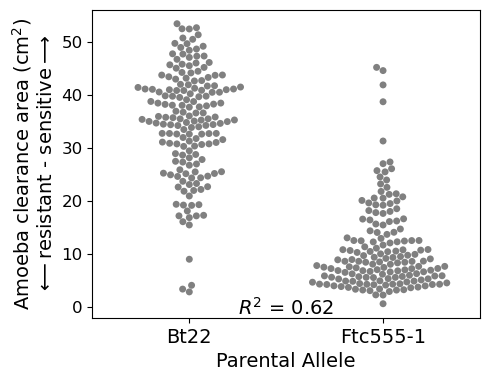

In [43]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
## Make a genotype by phenotype plot at QTL peak
## plto swarm
sns.swarmplot(x = "GT", y = "Halo", data = Qtl, color = "grey");
## plot regresison (we should remove this b/c we are not doing a regresson)
#sns.regplot(x = "GT", y = "Halo", data = Qtl, ci=False,
#            line_kws = {"alpha":0.8, "color":"red"}, 
#            scatter_kws = {"alpha":0});

plt.xticks([0,1], parents, fontsize = 14);
plt.yticks(fontsize = 12);
plt.xlabel("Parental Allele", fontsize = 14);
#plt.ylabel("Amoeba Clearance Area (cm$^2$)", fontsize = 14);
plt.ylabel(myylabel,fontsize=14)
plt.text(0.5,0,s='$R^2$ = 0.62',va='center',ha='center',fontsize=14)

plt.savefig("C:/Users/tsauters/Pictures/scientific figures/Amoeba_genotype_split_Chr8_Bt22xFtc555-1_aov.png", 
            dpi = 100, bbox_inches = "tight")

In [44]:
a = Qtl[Qtl.Halo == Qtl.Halo.max()].index

b = Qtl[Qtl.Halo == Qtl.Halo.min()].index

Qtl.loc[a], Qtl.loc[b]

(          GT       Halo
 PMY2646  0.0  53.490216,
           GT      Halo
 PMY2626  1.0  0.660214)

In [45]:
## What is the max clearance
## It cannot be more than 58 cm2
Qtl.Halo.max()

53.49021559999999

In [46]:
## sub divide and reconduct QTL mappin
Map_pop0 = Qtl[(Qtl.GT == 0)].index.tolist()
Map_pop1 =Qtl[(Qtl.GT == 1)].index.tolist()

## View number of progeny in each group
len(Map_pop0), len(Map_pop1)

(166, 156)

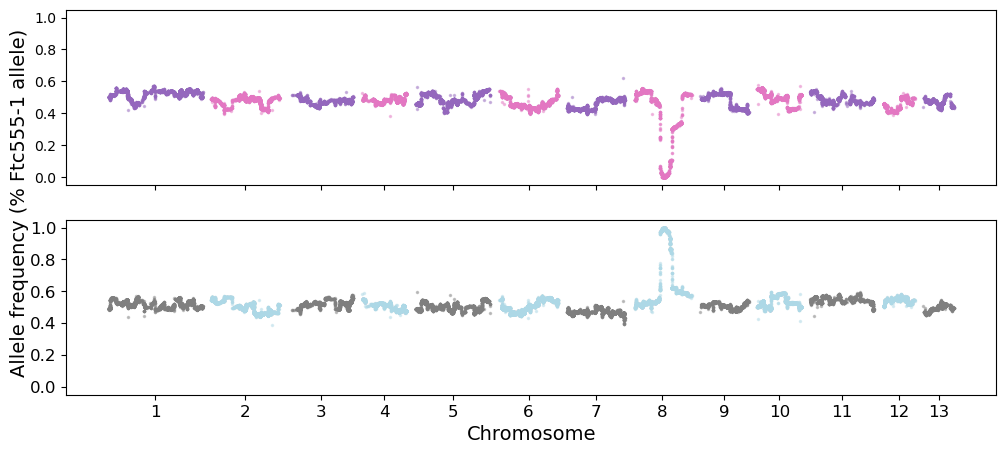

In [47]:
## Plot results of split (based on allele at QTL 8) QTL analysis
fig,ax = plt.subplots(2,1,figsize=(12,5), 
                      sharex = True, sharey = True) ## Makes a figure instance
for i,j in chrommap[:-1].iterrows(): ## For ech row in dataframe chrommap do this ...    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.sca(ax[0]) ## For Bt22 progeny
    plt.plot(temp.Pos.values+cumpos,
             temp[Map_pop0].mean(axis=1),
             '.',markersize=3,alpha=0.4,
             color='tab:purple' if i%2==0 else 'tab:pink'); ## plots the data x vs y

    
    plt.sca(ax[1]) ## For Ftc555-1 progeny
    plt.plot(temp.Pos.values+cumpos,
             temp[Map_pop1].mean(axis=1),
             '.',markersize=3,alpha=0.4,
            color='tab:grey' if i%2==0 else 'lightblue'); ## plots the data x vs y
    
plt.sca(ax[0])
plt.ylabel('Allele frequency (% Ftc555-1 allele)',fontsize=14,y=-0.1)
plt.sca(ax[1])
plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:-1], chrommap.Chrom[:-1],
           fontsize=12); ## set location, labels and fontsize of x tics.

#plt.savefig("../../FIGURES/Amoeba_Halo_Allele_Freq_split_Bt22xFtc555-1.png", 
#            dpi = 200, bbox_inches = "tight")

In [48]:
def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. 
        Return F-statistic.
    """
    coding = np.array(site,float)
    pheno = np.array(pheno,float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
#    print(ctry)
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    R = (len_yhat/len_y)**2
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F,R

def association_logPval(site, pheno):
    F,R = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [49]:
## For sub population with Bt22 allele at QTL
## conduct QTL mapping and merge results
## taking just p-value column
loci0 = geno[sorted(Map_pop0)].drop_duplicates()
loci0['Pval'] = loci0.apply(association_logPval, 
                            args=[Halo.loc[Map_pop0]['Halo'].values], 
                            axis=1)
pvaldf["Pval0"] = geno.merge(loci0)["Pval"].replace(np.inf,np.nan)

C:\Users\tsauters\AppData\Local\Temp\ipykernel_16140\3695812328.py:14: RuntimeWarning: invalid value encountered in double_scalars
  b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)


In [50]:
## For sub population with Ftc555-1 allele at QTL
## conduct QTL mapping and merge results
## taking just p-value column
loci1 = geno[sorted(Map_pop1)].drop_duplicates()

#loci1 = loci1[~(loci1.index.isin(pvaldf[(pvaldf.Pval1>10)].index))]
loci1['Pval'] = loci1.apply(association_logPval, 
                            args=[Halo.loc[sorted(Map_pop1), "Halo"]], 
                            axis=1)

pvaldf["Pval1"] = geno.merge(loci1)["Pval"].replace(np.inf,np.nan)

C:\Users\tsauters\AppData\Local\Temp\ipykernel_16140\3695812328.py:14: RuntimeWarning: invalid value encountered in double_scalars
  b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)


In [51]:
## view head of new p-values
pvaldf.head()[['QTL','Pval0','Pval1']]

,QTL,Pval0,Pval1
0,0.118804,0.384545,0.191848
1,0.130805,0.287316,0.217222
2,0.130805,0.287316,0.217222
3,0.130805,0.287316,0.217222
4,0.130805,0.287316,0.217222


In [58]:
threshold_sub

3.771803021489653

In [59]:
## Set significance threshold for QTL mapping
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
threshold_sub = 3.771803021489653 ## 0.05 threshold

## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno = Halo.loc[sorted(Map_pop1),'Halo'].values
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

## Gather loci and intiate null distrbution
loci = geno[sorted(Map_pop1)].drop_duplicates() 

if threshold_sub < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci.apply(association_logPval,
                               args=[perms_pheno[i]],
                               axis=1).replace(np.inf,np.nan).dropna().max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold_sub = np.percentile(null,95 if perms <= 1000 else 99)

In [62]:
threshold_sub0

3.381298590274601

In [63]:
## Set significance threshold for QTL mapping
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
threshold_sub0 = 3.381298590274601 ## 0.05 threshold

## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno = Halo.loc[sorted(Map_pop0),'Halo'].values
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

## Gather loci and intiate null distrbution
loci = geno[sorted(Map_pop0)].drop_duplicates() 

if threshold_sub0 < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci.apply(association_logPval,
                               args=[perms_pheno[i]],
                               axis=1).replace(np.inf,np.nan).dropna().max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold_sub0 = np.percentile(null,95 if perms <= 1000 else 99)

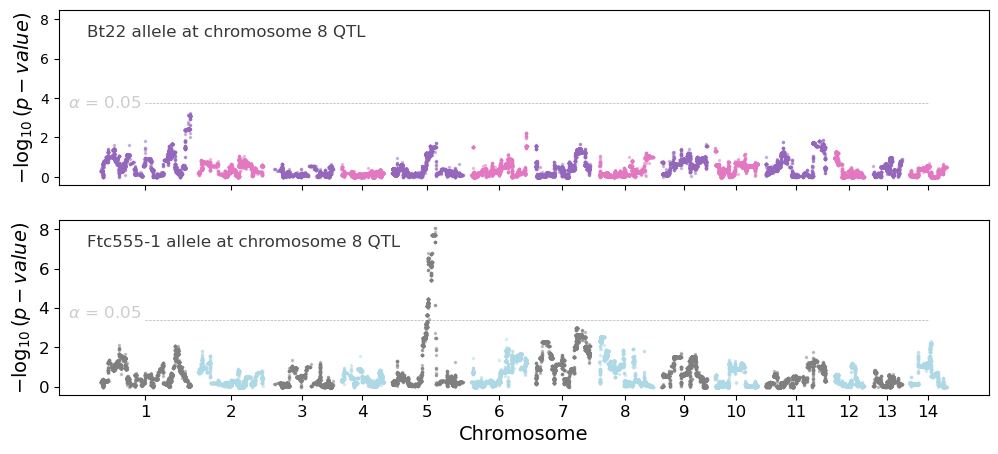

In [67]:
## Plot results of split (based on allele at QTL 8) QTL analysis
fig,ax = plt.subplots(2,1,figsize=(12,5), 
                      sharex = True, sharey = True) ## Makes a figure instance
for i,j in chrommap[:14].iterrows(): ## For ech row in dataframe chrommap do this ...    
    temp = pvaldf[(pvaldf.Chrom == j.Chrom)] ## subsets the dataframe on Chrom
    cumpos = j.Cumlen ## Assigns the cumlative postion from chrommap to
    
    plt.sca(ax[0]) ## For Bt22 progeny
    #plt.hlines(threshold_sub,0,19*10**6,alpha=0.5,
    #           linestyle='--',linewidth=1,color='k')
    plt.plot(temp.Pos.values+cumpos,temp.Pval0.values,
             '.',markersize=3,alpha=0.4,
             color='tab:purple' if i%2==0 else 'tab:pink'); ## plots the data x vs y

    
    plt.sca(ax[1]) ## For Ftc555-1 progeny

    
    
    plt.plot(temp.Pos.values+cumpos,temp.Pval1.values,
             '.',markersize=3,alpha=0.4,
            color='tab:grey' if i%2==0 else 'lightblue'); ## plots the data x vs y
    
for i in [0,1]:
    plt.sca(ax[i])
    plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
    plt.title("%s allele at chromosome 8 QTL"%parents[i], 
              x = .03, y = .8, ha = "left",fontsize=12,alpha=0.78)
    
    if i == 0:     
        plt.hlines(threshold_sub,chrommap.Midpts.min(),
               21*10**6,alpha=0.3,
                   linestyle='--',linewidth=0.5,color='k')
        plt.text(chrommap.Midpts.min()-100000,threshold_sub,
             '$\u03B1$ = 0.05',
                 fontsize=12,alpha=0.2,ha='right',va='center')
        
    else: 
        plt.hlines(threshold_sub0,chrommap.Midpts.min(),
               21*10**6,alpha=0.3,
                   linestyle='--',linewidth=0.5,color='k')
        plt.text(chrommap.Midpts.min()-100000,threshold_sub,
             '$\u03B1$ = 0.05',
                 fontsize=12,alpha=0.2,ha='right',va='center')
        


plt.xlabel('Chromosome',fontsize=14); ## add y label
plt.yticks(fontsize=12) ## Set fontsize of y ticks
plt.xticks(chrommap.Midpts[:14], chrommap.Chrom[:14],
           fontsize=12); ## set location, labels and fontsize of x tics.

plt.savefig("../../FIGURES/Amoeba_Halo_aov_QTL_split_Bt22xFtc555-1.png", 
            dpi = 200, bbox_inches = "tight")

In [ ]:
## Bring in bootstraps for QTL5
boots_chr5_path = '../../NOTES/Amoeba_halo_bootstraps_chr5.csv.gz'
boots_chr5 = pd.read_csv(boots_chr5_path)
boots_chr5.head()

In [ ]:
## Sub set qtl 5 data
qtl5 = pvaldf[(pvaldf.Chrom==5)]

In [ ]:
qtl5max = qtl5[(qtl5.Pval1==qtl5.Pval1.max())]
qtl5_l,qtl5_r = qtl5max.Pos.min(),qtl5max.Pos.max()
qtl5_l,qtl5_r

In [ ]:
qtl5max.Pval1.max()

In [ ]:
## Plot chromosome 5 QTL and CI
fig,ax = plt.subplots(1,2,figsize=(8,3))
plt.sca(ax[0])


## Plot qtl on chr. 5
plt.plot(qtl5.Pos,qtl5.Pval1,'.',color='grey',alpha=0.5);

## plot CI
[plt.hlines(j.Pval,j.Min,j.Max,color='r',
            alpha=0.1,linewidth=1) 
 for i,j in boots_chr5.iterrows()];

plt.sca(ax[1])

plt.plot(qtl5.Pos,qtl5.Pval1,'.',color='grey',alpha=0.5);

cil = boots_chr5.Min.median()
cir = boots_chr5.Max.median()

plt.hlines(9,cil,cir,color='r',linewidth=1)
plt.hlines(8.75,qtl5_l,qtl5_r,color='g',linewidth=1)

plt.vlines((1015000,1110000),7,10,color='k',alpha=0.2)

plt.ylim(7,10);plt.xlim(750000,1500000);

In [ ]:
qtl5[(qtl5.Pval1==qtl5.Pval1.max())].Pos.min()

In [ ]:
qtl5[(qtl5.Pval1==qtl5.Pval1.max())].Pos.max()

In [ ]:
## Gather information on chromosome 5 QTL
QTL5_ix = qtl5.Pval1.idxmax()
QTL5_gt = pvaldf.loc[QTL5_ix,:][Map_pop]
Qtl['QTL5'] = QTL5_gt
Qtl['Chromosome 5 QTL'] = Qtl['QTL5'].replace(dict(zip([0,1],parents)))
Qtl.head()

In [ ]:
## Set ylabel
myylabel = 'Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,3),sharey=True)
sns.swarmplot(x='GT',y='Halo',
              data=Qtl,hue='Chromosome 5 QTL')

plt.xticks([0,1],parents,fontsize=14)
plt.xlabel('Chromosome 8 QTL allele',fontsize=14)
lg = plt.legend(fontsize=14,bbox_to_anchor=(.9,1.35),ncol=2,
           title='Chromosome 5 QTL allele')
lg.get_title().set_fontsize(14)
plt.ylabel(myylabel,fontsize=14)
plt.yticks(fontsize=14);
#plt.savefig('../../FIGURES/Amoeba_Halo_by_genotype_QTL5_Bt22xFtc555-1.png',
#           dpi=100,bbox_inches='tight');

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(9,3),sharey=True)
plt.sca(ax[0])
sns.swarmplot(x='QTL5',y='Halo',
              data=Qtl[(Qtl.GT==0)],
              color='blue')

plt.title('Progeny with Bt22\nchromosome 8 QTL allele',fontsize=14)
plt.xticks([0,1],parents,fontsize=14)
plt.xlabel('Chromosome 5 QTL allele',fontsize=14)

plt.ylabel(myylabel,fontsize=14)
plt.yticks(fontsize=14);

plt.sca(ax[1])
sns.swarmplot(x='QTL5',y='Halo',
              data=Qtl[(Qtl.GT==1)],
              color='grey')

plt.title('Progeny with Bt22\nchromosome 8 QTL allele',fontsize=14)
plt.xticks([0,1],parents,fontsize=14)
plt.xlabel('Chromosome 5 QTL allele',fontsize=14)

plt.ylabel(' ',fontsize=14)
plt.subplots_adjust(wspace=0.1)
#plt.savefig('../../FIGURES/Amoeba_Halo_by_genotype_splits_Bt22xFtc555-1.png',
#           dpi=100,bbox_inches='tight');

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(6,4),sharey=False)
plt.sca(ax[0])
sns.swarmplot(x='GT',
              y='Halo',data=Qtl[(Qtl.GT==0)],size=5,
             color='grey')
plt.xlabel(' ')
plt.xticks([0],['Bt22'],fontsize=14)
plt.ylabel(myylabel, fontsize = 14);
plt.yticks(fontsize=14)
plt.ylim(0,58)
plt.sca(ax[1])
sns.swarmplot(x='Chromosome 5 QTL',
              y='Halo',data=Qtl[(Qtl.GT==1)],
              hue='Chromosome 5 QTL',size=5,
              palette=dict(zip(parents,['blue','tab:orange'])))
plt.xlabel(' ');plt.ylabel(' ')

ax[1].spines['left'].set_visible(False)
#ax.spines['top'].set_visible(False)

plt.xticks([0.5],['Ftc555-1'],fontsize=14);
plt.yticks([])
fig.text(x=0.5,y=-0.01,s='Chromosome 8 QTL allele',
         fontsize=14,va='center',ha='center')
lg = plt.legend(fontsize=14,bbox_to_anchor=(1.3,1.25),ncol=2,
           title='Chromosome 5 QTL allele')
lg.get_title().set_fontsize(14)
plt.ylim(0,58)
plt.subplots_adjust(wspace=-.2)
plt.text(0.5,50,s='$R^2$ = 0.186',va='center',ha='center',fontsize=14)

plt.savefig("C:/Users/Thomas/Pictures/scientific figures/Amoeba_by_genotype_split_Chr5_Bt22xFtc555-1.png", 
                       dpi = 200, bbox_inches = "tight")

In [ ]:
Qtl.Halo.max(),Qtl.Halo.min()

In [ ]:
centlocs = pd.read_csv('C:/Users/Thomas/Downloads/H99_Vikas_Centromere_locations.csv',index_col=0)
centlocs.head()

In [ ]:
boots = pd.read_csv('../../NOTES/Amoeba_halo_bootstraps.csv.gz')
boots.sort_values('Pval',inplace=True)
boots.head()

In [ ]:
boots.shape

In [ ]:
for k,(i,b) in enumerate(boots.iterrows()):
    
    plt.hlines(b.Pval,b.Min,b.Max,
               color='r',alpha=0.2,linewidth=1)
    
qtl8 = pvaldf[(pvaldf.Chrom==8)]

#plt.vlines(boots.Max.mean(),38,42,color='g')
plt.plot(qtl8.Pos.values,qtl8.QTL.values,
         '.',color='grey',alpha=0.5);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14) ## Add x label.
plt.xlabel('Chromosome 8 Coordinate (Mb)',fontsize=14);
#plt.vlines(boots.Max.mean(),35,45,color='g')
#plt.vlines(boots.Min.mean(),35,45,color='g')

p,l = plt.xticks()
plt.xticks(p[1:-1],p[1:-1]/(10**6));
#plt.savefig('../../FIGURES/Amoeba_Halo_QTL_CI.png',
#            dpi=100,bbox_inches='tight');

In [ ]:
## Make a copy of just chormosome 8 results
qtl8 = pvaldf[(pvaldf.Chrom==8)].copy()

In [ ]:
pvaldf

In [ ]:
## Find the QTL plateau
plat = pvaldf[(pvaldf.Chrom==8) & (pvaldf.QTL>=pvaldf.QTL.max())]
plat_left,plat_right = plat.Pos.min(),plat.Pos.max()

In [ ]:
to_correct = pvaldf[(pvaldf.Chrom==8) & 
       (pvaldf.Pos>=plat_left) & 
       (pvaldf.Pos<=plat_right) & (pvaldf.QTL>30)]

In [ ]:
to_correct[(to_correct.QTL<pvaldf.QTL.max())]

In [ ]:
## For initial analysis set the left and right sides of QTL
left,right = 650000,850000

In [ ]:
co = qtl8[(qtl8.Pos>=left) & (qtl8.Pos<=right)][Map_pop].diff(axis=0).abs().sum()
qtl_recombs = co[(co>0)].index.tolist()
len(qtl_recombs)

In [ ]:
qtl_recombs_sorted = Halo[(Halo.PMY.isin(qtl_recombs))
                         ].sort_values('Halo').PMY.tolist()

In [ ]:
#qtl_genes = pd.read_csv('../../NOTES/QTL_gene_analysis.csv')
qtl_genes = pd.read_csv('../../NOTES/Bt22xFtc555-1_gene_analysis.1.2.3.5.6.8.10.11.csv.gz')
qtl_genes.tail()

In [ ]:
boots.Min.mean(),boots.Max.mean()

In [ ]:
qtl8_ci_genes = qtl_genes[(qtl_genes.Chrom==8) & 
                  (qtl_genes.End>=boots.Min.mean()-1000) & 
                  (qtl_genes.Start <= boots.Max.mean()+1000)]

qtl5_ci_genes = qtl_genes[(qtl_genes.Chrom==5) & 
                  (qtl_genes.End>=qtl5[(qtl5.Pval1>=qtl5.Pval1.max())].Pos.min()-1000) & 
                  (qtl_genes.Start<=qtl5[(qtl5.Pval1>=qtl5.Pval1.max())].Pos.max()+1000)]

In [ ]:
qtl8_ci_genes.drop_duplicates().shape,qtl5_ci_genes.shape

In [ ]:
qtl8_names = pd.read_csv('../../NOTES/QTL8_amoeba_gene_names.csv')
qtl8_names.head()

In [ ]:
qtl5_names = pd.read_csv('../../NOTES/QTL5_amoeba_gene_names.csv',header=None)
qtl5_names.columns=['Gene','Name']
qtl5_names.head()

In [ ]:
qtl8_ci_genes.head()

In [ ]:
## For QTL 8
qtl8_unique_genes_ci = qtl8_ci_genes.groupby('Gene').agg('max').sort_values('Nonsyn').reset_index()

names = []
for i,j in qtl8_unique_genes_ci.iterrows():
    if j.Gene in qtl8_names.Gene.tolist():
        gn = qtl8_names[(qtl8_names.Gene==j.Gene)].Name.min()
    else:
        gn = j.Gene
    names.append(gn)

qtl8_unique_genes_ci['Name'] = names


## For QTL 5
qtl5_unique_genes_ci = qtl5_ci_genes.groupby('Gene').agg('max').sort_values('Nonsyn').reset_index()

names = []
for i,j in qtl5_unique_genes_ci.iterrows():
    if j.Gene in qtl5_names.Gene.tolist():
        gn = qtl5_names[(qtl5_names.Gene==j.Gene)].Name.min()
    else:
        gn = j.Gene
    names.append(gn)

qtl5_unique_genes_ci['Name'] = names

qtl8_unique_genes_ci.shape,qtl5_unique_genes_ci.shape

In [ ]:
qtl5_unique_genes_ci.head()

In [ ]:
qtl8_unique_genes_ci[
    (qtl8_unique_genes_ci.Description!='hypothetical protein')
     ].sort_values('Gene')

In [ ]:
qtl8_unique_genes_ci = qtl8_unique_genes_ci.replace("ClpB", "HSP78")

In [ ]:
cds = gff[(gff.Type=='CDS')].copy()
cds['ParentN'] = [int(a[-1]) for a in cds.Parent.values]

In [ ]:
newylabel = 'F$_1$ Ranked amoeba clearance\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

qtl8 = pvaldf[(pvaldf.Chrom==8)].copy()
fig,ax = plt.subplots(2,1,figsize=(12,8),sharex=True)
plt.sca(ax[0])


## Add annottion of sequence similarity
xl280y = np.round(pvaldf.QTL.max())+3
plt.text(np.mean([666895,739631]),50,
         s='Region with high sequence similarity (82%) to XL280 Chr.7 QTL',
         ha='center',va='bottom',fontsize=7,color='k')
plt.hlines(xl280y,666895,739631,color='k');
[plt.vlines(k,xl280y-.5,
            xl280y+.5,
            color='k') for k in [666895,739631]]

## annotate
ciy = np.round(pvaldf.QTL.max())+1
plt.vlines(boots.Max.mean(),ciy-0.5,ciy+0.5,color='k')
plt.vlines(to_correct.Pos.min(),ciy-0.5,ciy+0.5,color='k')
plt.hlines(ciy,to_correct.Pos.min(),boots.Max.mean(),
          color='k')
plt.text(np.mean([boots.Min.mean(),boots.Max.mean()]),ciy+0.5,
        '95% CI',color='k',fontsize=7,
         va='center',ha='center')

#qtl8.drop(to_correct[(to_correct.Pval<pvaldf.Pval.max())].index,
#         axis=0,inplace=True)
plt.plot(qtl8.Pos.values,qtl8.QTL.values,
         '.',color='grey',alpha=0.7);
plt.ylim(30,50)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12,y=0.4) ## Add x label.
plt.yticks(np.arange(30,50,5),fontsize=12)

plt.xlim(660000,780000)


ax[0].spines['top'].set_visible(False)

ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis

ax1.spines['top'].set_visible(False)
plt.sca(ax1)

plt.ylabel('# of non-synonymous\nchanges',fontsize=12,y=0.3)

for i,j in qtl8_unique_genes_ci.iterrows():
    ygm = 0.051 if i%2==0 else -0.051
    plt.hlines(j.Nonsyn+ygm,
               j.Start,j.End,
               color='blue' if j.Strand > 0 else 'red',
               alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
              linewidth=1);
    
    cdsg = cds[(cds.Gene==j.Gene) & (cds.ParentN==int(j.Parent[-1]))]
    
    for z,l in cdsg.iterrows():
        plt.hlines(j.Nonsyn+ygm,l.Start,l.End,
                   color='blue' if j.Strand > 0 else 'red',
                   alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
                  linewidth=3)
    
    gene_name = '%s\n(%s)'%(j.Name,j.Gene) if j.Name!=j.Gene else j.Gene
    plt.text(np.mean([j.Start,j.End]),
             j.Nonsyn+ygm + (0.1 if j.Strand<0 else -0.1),
             #j.Nonsyn+ygm+(0.1 if j.Name==j.Gene else (0 if (j.Strand<0) else -0.3)),
             s = gene_name,
             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
             fontstyle='italic',
             color='blue' if j.Strand>0 else 'red',
             #fontsize=8 if j.Name != j.Gene else 4,
             fontsize=5,
             va='bottom' if j.Strand<0 else 'top',
             #rotation = 90 if j.Name == j.Gene else 0,
             rotation = 90,
             ha='center')
          
plt.ylim(-.25,5.5) 
plt.yticks(np.arange(qtl8_unique_genes_ci.Nonsyn.max()+1),
           fontsize=12)
plt.xlim(660000,780000)

plt.sca(ax[1])
for i,j in enumerate(qtl_recombs_sorted):
    
    haplo = pvaldf[(pvaldf.Chrom==8)]
    
    bt22 = haplo[(haplo[j])==0].Pos.values
    ftc5 = haplo[(haplo[j])==1].Pos.values
    
    plt.plot(bt22,(i+1)*np.ones(len(bt22)),'.',
             color='tab:blue',label='Bt22' if i == 0 else None)
    plt.plot(ftc5,(i+1)*np.ones(len(ftc5)),'.',
             color='tab:orange',label='Ftc555-1' if i == 0 else None)
plt.legend(bbox_to_anchor=(0.2,-0.1),ncol=2,title='Genotype')
[ax[1].spines[ts].set_visible(False) for ts in ['top','left','right']]
plt.xlim(left-1000,right+1000);
plt.subplots_adjust(hspace=0.081);
plt.ylabel(newylabel,fontsize=12)
plt.yticks([])
plt.xticks(fontsize=12)
plt.xlabel('Chromosome 8 coordinate (bp)',fontsize=12);
plt.xlim(663000,765000)
ws = fig.add_axes([0.051,0.8,.1,.1])
[ws.spines[ts].set_visible(False) 
 for ts in ['top','bottom','left','right']]
plt.xticks([]);plt.yticks([])

ws = fig.add_axes([0.85,0.8,.1,.1])
[ws.spines[ts].set_visible(False) 
 for ts in ['top','bottom','left','right']]
plt.xticks([]);plt.yticks([])

plt.subplots_adjust(hspace=0.15)

axcoords = [-0.19,0.125,0.25,0.34]

axp = fig.add_axes(axcoords)

sns.swarmplot(x = "GT", y = "Halo", 
              data = Qtl, color = "grey",
              size=4,alpha=0.5);
sns.regplot(x = "GT", y = "Halo", data = Qtl, ci=False,
            line_kws = {"alpha":0.8, "color":"red"}, 
            scatter_kws = {"alpha":0});

plt.xticks([0,1], parents, fontsize = 14);
plt.yticks(fontsize = 12);
plt.xlabel("Parental Allele", fontsize = 14);
plt.ylabel(myylabel,fontsize=14)
plt.title(x=0.5,y=0.85,label='$R^2$ = 0.62',
         va='center',ha='center',fontsize=14)

plt.plot(Qtl.groupby('GT').mean().index,
         Qtl.groupby('GT').mean().Halo,
         'k_',markersize=10)


[plt.plot(Qtl.loc[p].GT,
         Qtl.loc[p].Halo,'^',
          color = 'tab:blue' if i == 0 else 'tab:orange',
          alpha=0.8,markersize=10,
        ) for i,p in enumerate(Parent_PMY)]
plt.ylim(0,60);

#plt.savefig('../../FIGURES/Amoeba_Halo_QTL_8_%s_%s_kb_Haplotype_Map.pdf'%(int(to_correct.Pos.min()/1000),int(boots.Max.mean()/1000)),
#            dpi=300,bbox_inches='tight')

In [ ]:
newylabel = 'F$_1$ Ranked amoeba clearance\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

qtl8 = pvaldf[(pvaldf.Chrom==8)].copy()
fig,ax = plt.subplots(1,1,figsize=(12,4),sharex=True)
plt.sca(ax)


## Add annottion of sequence similarity
xl280y = np.round(pvaldf.QTL.max())+1.5
plt.text(np.mean([666895,739631]), xl280y + .5,
         s='Region with high sequence similarity (82%) to XL280 Chr.7 QTL',
         ha='center',va='bottom',fontsize=7,color='k')
plt.hlines(xl280y,666895,739631,color='k');
[plt.vlines(k,xl280y-.3,
            xl280y+.3,
            color='k') for k in [666895,739631]]

## annotate
ciy = np.round(pvaldf.QTL.max())+.5
plt.vlines(boots.Max.mean(),ciy-0.3,ciy+0.3,color='k')
plt.vlines(to_correct.Pos.min(),ciy-0.3,ciy+0.3,color='k')
plt.hlines(ciy,to_correct.Pos.min(),boots.Max.mean(),
          color='k')
plt.text(np.mean([boots.Min.mean(),boots.Max.mean()]),ciy+0.5,
        '95% CI',color='k',fontsize=7,
         va='center',ha='center')

#qtl8.drop(to_correct[(to_correct.Pval<pvaldf.Pval.max())].index,
#         axis=0,inplace=True)
plt.plot(qtl8.Pos.values,qtl8.QTL.values,
         '.',color='grey',alpha=0.7);
plt.ylim(36,45)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12,y=0.4) ## Add x label.
#plt.yticks(np.arange(36,46,2),fontsize=12)
plt.yticks([36, 38, 40, 42, 44], fontsize = 12)

ax.spines['top'].set_visible(False)

for i,j in qtl8_unique_genes_ci.iterrows():
    ygm = 38 if j.Strand > 0 else 37
    plt.hlines(ygm,
               j.Start,j.End,
               color='blue' if j.Strand > 0 else 'red',
               alpha = 0.3 if j.Description == 'hypothetical protein' else 0.8,
              linewidth=3);
    
    cdsg = cds[(cds.Gene==j.Gene) & (cds.ParentN==int(j.Parent[-1]))]
    
    for z,l in cdsg.iterrows():
        plt.hlines(ygm,l.Start,l.End,
                   color='blue' if j.Strand > 0 else 'red',
                   alpha = 0.3 if j.Description == 'hypothetical protein' else 0.8,
                  linewidth=6)
        
#        gene_name = '%s\n(%s)'%(j.Name,j.Gene) if j.Name!=j.Gene else j.Gene
#    plt.text(np.mean([j.Start,j.End]),
#             ygm + (0.25 if j.Strand<0 else 0.75),
#             s = gene_name,
#             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
#             fontstyle='italic',
#             color='blue' if j.Strand>0 else 'red',
#             #fontsize=8 if j.Name != j.Gene else 4,
#             fontsize=5,
#             va='bottom' if j.Strand<0 else 'top',
#              rotation = 0,
#             ha='center')

        gene_name = j.Name if j.Name!=j.Gene else ' '
    plt.text(np.mean([j.Start,j.End]),
             ygm + (0.2 if j.Strand<0 else 0.5),
             s = gene_name,
             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
             fontstyle='italic',
             color='blue' if j.Strand>0 else 'red',
             #fontsize=8 if j.Name != j.Gene else 4,
             fontsize=5,
             va='bottom' if j.Strand<0 else 'top',
             #rotation = 90 if j.Name == j.Gene else 0,
             rotation = 0,
             ha='center')
    
plt.xticks(fontsize=12)
plt.xlabel('Chromosome 8 coordinate (bp)',fontsize=12);
plt.xlim(663000,765000)

#plt.savefig("C:/Users/Thomas/Pictures/scientific figures/QTL_overlap.png", 
#                       dpi = 200, bbox_inches = "tight")

In [ ]:
newylabel = 'F$_1$ Ranked amoeba clearance\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

qtl8 = pvaldf[(pvaldf.Chrom==8)].copy()
fig,ax = plt.subplots(1,1,figsize=(12,4),sharex=True)
plt.sca(ax)


## Add annottion of sequence similarity
xl280y = np.round(pvaldf.QTL.max())+1.5
plt.text(np.mean([666895,739631]), xl280y + .5,
         s='Region with high sequence similarity (82%) to XL280 Chr.7 QTL',
         ha='center',va='bottom',fontsize=7,color='k')
plt.hlines(xl280y,666895,739631,color='k');
[plt.vlines(k,xl280y-.3,
            xl280y+.3,
            color='k') for k in [666895,739631]]

## annotate
ciy = np.round(pvaldf.QTL.max())+.5
plt.vlines(boots.Max.mean(),ciy-0.3,ciy+0.3,color='k')
plt.vlines(to_correct.Pos.min(),ciy-0.3,ciy+0.3,color='k')
plt.hlines(ciy,to_correct.Pos.min(),boots.Max.mean(),
          color='k')
plt.text(np.mean([boots.Min.mean(),boots.Max.mean()]),ciy+0.5,
        '95% CI',color='k',fontsize=7,
         va='center',ha='center')

#qtl8.drop(to_correct[(to_correct.Pval<pvaldf.Pval.max())].index,
#         axis=0,inplace=True)
plt.plot(qtl8.Pos.values,qtl8.QTL.values,
         '.',color='grey',alpha=0.7);
plt.ylim(38,45)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12,y=0.4) ## Add x label.
#plt.yticks(np.arange(36,46,2),fontsize=12)
plt.yticks([38, 40, 42, 44], fontsize = 12)

ax.spines['top'].set_visible(False)

for i,j in qtl8_unique_genes_ci.iterrows():
    ygm = 40 if j.Strand > 0 else 39
    plt.hlines(ygm,
               j.Start,j.End,
               color='blue' if j.Strand > 0 else 'red',
               alpha = 0.3 if j.Description == 'hypothetical protein' else 0.8,
              linewidth=3);
    
    cdsg = cds[(cds.Gene==j.Gene) & (cds.ParentN==int(j.Parent[-1]))]
    
    for z,l in cdsg.iterrows():
        plt.hlines(ygm,l.Start,l.End,
                   color='blue' if j.Strand > 0 else 'red',
                   alpha = 0.3 if j.Description == 'hypothetical protein' else 0.8,
                  linewidth=6)
        

        gene_name = j.Name if j.Name!=j.Gene else ' '
    plt.text(np.mean([j.Start,j.End]),
             ygm + (0.2 if j.Strand<0 else 0.5),
             s = gene_name,
             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
             fontstyle='italic',
             #fontsize=8 if j.Name != j.Gene else 4,
             fontsize=8,
             va='bottom' if j.Strand<0 else 'top',
             #rotation = 90 if j.Name == j.Gene else 0,
             rotation = 0,
             ha='center')
    
plt.xticks(fontsize=12)
plt.xlabel('Chromosome 8 coordinate (bp)',fontsize=12);
plt.xlim(663000,765000)

plt.savefig("C:/Users/Thomas/Pictures/scientific figures/QTL_overlap.png", 
                       dpi = 200, bbox_inches = "tight")

In [ ]:
cds

In [ ]:
qtl8_unique_genes_ci

In [ ]:
gene_8_check = qtl_genes[(qtl_genes.Chrom==8) & 
                         (qtl_genes.Start>=qtl8_unique_genes_ci.Start.min()) &
                         (qtl_genes.End<=qtl8_unique_genes_ci.End.max())]
len(gene_8_check.Gene.unique())

In [ ]:
len([g for g in gene_8_check.Gene.unique().tolist() 
 if g not in qtl8_unique_genes_ci.Gene.unique().tolist() ])

In [ ]:
g = qtl8_unique_genes_ci.Gene.unique()[0]

In [ ]:
qtl_genes[(qtl_genes.Gene==g)]

In [ ]:
savecsvpath = '../../NOTES/Amoeba_Halo_QTL_8_Haplotype_Genes.csv'
qtl8_genes = qtl_genes[(qtl_genes.Gene.isin(qtl8_unique_genes_ci.Gene))
         ].sort_values(['Start','Nonsyn'])
qtl8_genes.to_csv(savecsvpath)

In [ ]:
qtl8_genes_uni = qtl8_genes[['Gene','Chrom','Start','End',
                             'Nvars','Nonsyn','Description','Strand']
                           ].groupby('Gene').agg('max')

qtl8_genes_uni.to_csv('../../NOTES/Amoeba_Halo_QTL_8_Haplotype_Genes_Unique.csv')

In [ ]:
qtl8_genes.to_csv('../../NOTES/Amoeba_Halo_QTL_8_Haplotype_Genes_by_Strain.csv')

In [ ]:
qtl8_genes[(qtl8_genes.Altstop>1)]

In [ ]:
qtl8_genes_uni.shape

In [ ]:
qtl8_genes_uni[(qtl8_genes_uni.Description!='hypothetical protein')].shape

In [ ]:
qtl8_genes_uni.head()

In [ ]:
Qtl['QTL5'] = Qtl['QTL5'].apply(float)

In [ ]:
Map_pop1[:5]

In [ ]:
Qtl[(Qtl.GT==1)].index[:5]

In [ ]:
qtl5_unique_genes_ci

In [ ]:
co_perseg = qtl5[(qtl5.Pos>=qtl5_l-10000) & 
                 (qtl5.Pos<=qtl5_r+10000)][Map_pop1
                        ].diff(axis=0).abs().sum(axis=0)

co5_segs = co_perseg[(co_perseg>0)].index

co5_segs_sorted = Qtl.loc[co5_segs].sort_values('Halo').index.tolist()

qtl5 = pvaldf[(pvaldf.Chrom==5) & 
              (pvaldf.Pos>=qtl5_l-10000) & 
              (pvaldf.Pos<=qtl5_r+10000) & 
              (pvaldf.Pval1>=2)
             ].copy()
fig,ax = plt.subplots(2,1,figsize=(12,8),sharex=True)
plt.sca(ax[0])


## Plot chromosome 5 QTL
plt.plot(qtl5.Pos.values,qtl5.Pval1.values,
         '.',color='grey',alpha=0.7);
plt.ylim(2,10)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12,y=0.5) ## Add x label.
plt.yticks(fontsize=12)
plt.xlim(qtl5_l+10000,qtl5_r+10000);

## Plot QTL 5 CI
ymod = 1.5
ciy = np.round(qtl5.Pval1.max()) + ymod 
cil = qtl5[(qtl5.Pval1>=qtl5.Pval1.max())].Pos.min()#boots_chr5.Min.mean()
cir = qtl5[(qtl5.Pval1>=qtl5.Pval1.max())].Pos.max()#boots_chr5.Max.mean()

plt.hlines(ciy,cil,cir,color='k')
plt.vlines(cil,ciy-0.5,ciy+0.5,color='k')
plt.vlines(cir,ciy-0.5,ciy+0.5,color='k');
plt.text(np.mean([cil,cir]),ciy,'95% CI',
         fontsize=12,ha='center',va='bottom')

ax[0].spines['top'].set_visible(False)
ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
ax1.spines['top'].set_visible(False)
plt.sca(ax1)
plt.ylabel('# of non-synonymous\nchanges',fontsize=12,y=0.3)
for i,j in qtl5_unique_genes_ci.iterrows():
    ygm = 0.051 if i%2==0 else -0.051
    plt.hlines(j.Nonsyn+ygm,
               j.Start,j.End,
               color='blue' if j.Strand > 0 else 'red',
               alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
              linewidth=1);
    
    cdsg = cds[(cds.Gene==j.Gene) & (cds.ParentN==int(j.Parent[-1]))]
    
    for z,l in cdsg.iterrows():
        plt.hlines(j.Nonsyn+ygm,l.Start,l.End,
                   color='blue' if j.Strand > 0 else 'red',
                   alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
                  linewidth=3)
    
    
    gene_name = '%s\n(%s)'%(j.Name,j.Gene) if j.Name!=j.Gene else j.Gene
    plt.text(np.mean([j.Start,j.End]),
             j.Nonsyn+ygm + (0.1 if j.Strand<0 else -0.1),
             s = gene_name,
             alpha = 0.5 if j.Description == 'hypothetical protein' else 0.8,
             fontstyle='italic',
             color='blue' if j.Strand>0 else 'red',
             fontsize=5,
             va='bottom' if j.Strand<0 else 'top',
             rotation = 90,
             ha='center')
          
plt.ylim(-.25,3) 
plt.yticks(np.arange(qtl5_unique_genes_ci.Nonsyn.max()+1),
           fontsize=12)

## Plot recombinant progeny
plt.sca(ax[1])
for i,j in enumerate(co5_segs_sorted):
    
    haplo = qtl5
    
    bt22 = haplo[(haplo[j])==0].Pos.values
    ftc5 = haplo[(haplo[j])==1].Pos.values
    
    plt.plot(bt22,(i+1)*np.ones(len(bt22)),'.',
             color='tab:blue',label='Bt22' if i == 0 else None)
    plt.plot(ftc5,(i+1)*np.ones(len(ftc5)),'.',
             color='tab:orange',label='Ftc555-1' if i == 0 else None)
plt.legend(bbox_to_anchor=(0.2,-0.1),ncol=2,title='Genotype')
[ax[1].spines[ts].set_visible(False) for ts in ['top','left','right']]

plt.yticks([])
plt.ylabel(newylabel,fontsize=12)
plt.xlim(qtl5_l-10000,qtl5_r+10000);
xs,ps = plt.xticks()

plt.xticks(xs[1:-1],[int(x/1000) for x in xs[1:-1]], fontsize=12)
plt.xlabel('Chromosome 5 coordinate (kb)',fontsize=12);

axcoords = [-0.19,0.125,0.25,0.34]

axp = fig.add_axes(axcoords)

qtl5r2 = np.round(ss.pearsonr(Qtl[(Qtl.GT==1)].QTL5.values,
            Qtl[(Qtl.GT==1)].Halo.values)[0]**2,2)

sns.swarmplot(x = "QTL5", y = "Halo", 
              data = Qtl[(Qtl.GT==1)], color = "grey",
              size=4,alpha=0.5);
sns.regplot(x = "QTL5", y = "Halo", data = Qtl[(Qtl.GT==1)], ci=False,
            line_kws = {"alpha":0.8, "color":"red"}, 
            scatter_kws = {"alpha":0});

plt.xticks([0,1], parents, fontsize = 14);
plt.yticks(fontsize = 12);
plt.xlabel("Parental Allele", fontsize = 14);
plt.ylabel(myylabel,fontsize=14)
plt.title(x=0.5,y=0.85,label='$R^2$ = %s'%qtl5r2,
         va='center',ha='center',fontsize=14)

plt.plot(Qtl[(Qtl.GT==1)].groupby('QTL5').mean().index,
         Qtl[(Qtl.GT==1)].groupby('QTL5').mean().Halo,
         'k_',markersize=10)

[plt.plot(Qtl.loc[p].QTL5,
         Qtl.loc[p].Halo,'^',
          color = 'tab:blue' if i == 0 else 'tab:orange',
          alpha=0.8,markersize=10,
        ) for i,p in enumerate(Parent_PMY)]

plt.ylim(0,60)
#plt.savefig('../../FIGURES/Amoeba_Halo_QTL_5_%s_%s_kb_Haplotype_Map.pdf'%(int(cil/1000),int(cir/1000)),
#            dpi=300,bbox_inches='tight');

In [ ]:
gene_5_check = qtl_genes[(qtl_genes.Chrom==5) & 
                         (qtl_genes.Start>=qtl5_unique_genes_ci.Start.min()) &
                         (qtl_genes.End<=qtl5_unique_genes_ci.End.max())]
len(gene_5_check.Gene.unique())

In [ ]:
len([g for g in gene_5_check.Gene.unique().tolist() 
 if g not in qtl5_unique_genes_ci.Gene.unique().tolist() ])

In [ ]:
savecsvpath = '../../NOTES/Amoeba_Halo_QTL_5_Haplotype_Genes.csv'
qtl5_genes = qtl_genes[(qtl_genes.Gene.isin(qtl5_unique_genes_ci.Gene))
         ].sort_values(['Start','Nonsyn'])
qtl5_genes.to_csv(savecsvpath)

In [ ]:
qtl5_genes.Gene.unique().shape

In [ ]:
qtl5_genes[(qtl5_genes.Refstop>1)]

In [ ]:
qtl5_genes[(qtl5_genes.Altstop>1)]

In [ ]:
qtl5_genes_uni = qtl5_genes[['Gene','Chrom','Start','End',
                             'Nvars','Nonsyn','Description','Strand']
                           ].groupby('Gene').agg('max')

qtl5_genes_uni.to_csv('../../NOTES/Amoeba_Halo_QTL_5_Haplotype_Genes_Unique.csv')

In [ ]:
qtl5_genes_uni.head()

In [ ]:
qtl5_genes[(qtl5_genes.Gene=='CNAG_01138')]

In [ ]:
qtl5_genes_uni.shape

In [ ]:
qtl5_genes_uni[(qtl5_genes_uni.Description!='hypothetical protein')].shape

In [ ]:
#pd.DataFrame(qtl_recombs_sorted
#            ).to_csv('../../NOTES/Amoeba_halo_QTL_recombinant_segregants.csv')

In [ ]:
## Bring in additional mods
import statsmodels.formula.api as smf

In [ ]:
reg = smf.ols('Halo~GT',data=Qtl).fit()
reg.summary()

In [ ]:
reg5 = smf.ols('Halo~QTL5',data=Qtl[(Qtl.GT==1)]).fit()
reg5.summary()

In [ ]:
## View data frame
Qtl.head()

In [ ]:
## Save out results of QTL
Qtl.to_csv('../../NOTES/Bt22xFtc555-1_QTL8_genotype_phenotype.csv');

In [ ]:
## Load list of bam files used in calling variatns at SNPs
bams = open('../listofbams.txt','r').readlines()

## How many are there?
len(bams)

In [ ]:
## Sub set the list bams in QTL mapping
qtlbams = sorted([b.split('\n')[0] for b in bams if 
           b.split('/')[-1].split('_S')[0] 
                  in Map_pop])

## how many are there?
len(qtlbams)

In [ ]:
## Write to file
open('../qtllistofbams.txt','w').writelines('\n'.join(qtlbams))

In [ ]:
## load depth file and view head
depth = pd.read_csv('../../NOTES/Depth_by_sample.csv.gz',header=0,
                   names=['Strain','DP','AR','MI'])

In [ ]:
## Examine DP of recombinant strains
depth[(depth.Strain.isin(qtl_recombs_sorted+Parent_PMY))].sort_values('DP').head()

In [ ]:
## Save out QTL dataframe
#pvaldf.to_csv('../../NOTES/Bt22xFtc555-1_QTL.csv.gz')